# Changing Fourier Conventions

The ``powerbox`` package allows for arbitrary Fourier conventions. Since (continuous) Fourier Transforms can be defined using different definitions of the frequency term, and varying normalisations, we allow any consistent combination of these, using the same parameterisation that Mathematica uses, i.e.:

$$ F(k) = \left(\frac{|b|}{(2\pi)^{1-a}}\right)^{n/2} \int f(r) e^{-i b\mathbf{k}\cdot\mathbf{r}} d^n\mathbf{r} $$

for the forward-transform and 

$$ f(r) = \left(\frac{|b|}{(2\pi)^{1+a}}\right)^{n/2} \int F(k) e^{+i b\mathbf{k}\cdot\mathbf{r}} d^n \mathbf{k} $$

for its inverse. Here $n$ is the number of dimensions in the transform, and $a$ and $b$ are free to be any real number. Within ``powerbox``, $b$ is taken to be positive.

The most common choice of parameters is $(a,b) = (0,2\pi)$, which are the parameters that for example ``numpy`` uses. In cosmology (a field which ``powerbox`` was written in the context of), a more usual choice is $(a,b)=(1,1)$, and so these are the defaults within the ``PowerBox`` classes. 

In this notebook we provide some examples on how to deal with these conventions.

## Doing the DFT right.

In many fields, we are concerned primarily with the *continuous* FT, as defined above. However, typically we must evaluate this numerically, and therefore use a DFT or FFT. While the conversion between the two is simple, it is all too easy to forget which factors to normalise by to get back the analogue of the continuous transform. 

That's why in ``powerbox`` we provide some fast fourier transform functions that do all the hard work for you. They not only normalise everything correctly to produce the continuous transform, they also return the associated fourier-dual co-ordinates. And they do all this for arbitrary conventions, as defined above. And they work for any number of dimensions.

Let's take a look at an example, using a simple Gaussian field in 2D:

$$ f(x) = e^{-\pi r^2}, $$

where $r^2 = x^2 + y^2.$

The Fourier transform of this field, using the standard mathematical convention is:

$$ \int e^{-\pi r^2} e^{-2\pi i k\cdot x} d^2x = e^{-\pi k^2}, $$

where $k^2 = k_x^2 + k_y^2$. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from powerbox import fft,ifft
from powerbox.powerbox import _magnitude_grid
import powerbox as pbox

In [2]:
pbox.__version__

'0.5.5'

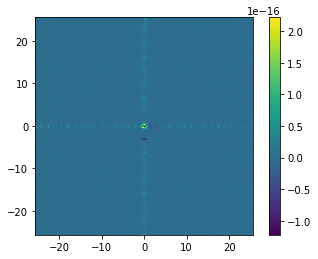

In [3]:
# Parameters of the field
L = 10.
N = 512
dx = L/N

x = np.arange(-L/2,L/2,dx)[:N] # The 1D field grid
r = _magnitude_grid(x,dim=2)   # The magnitude of the co-ordinates on a 2D grid
field = np.exp(-np.pi*r**2)    # Create the field

# Generate the k-space field, the 1D k-space grid, and the 2D magnitude grid.
k_field, k, rk = fft(field,L=L,          # Pass the field to transform, and its size 
                     ret_cubegrid=True   # Tell it to return the grid of magnitudes.
                    )

# Plot the field minus the analytic result
plt.imshow(np.abs(k_field)-np.exp(-np.pi*rk**2),extent=(k.min(),k.max(),k.min(),k.max()))
plt.colorbar();

We can now of course do the inverse transform, to ensure that we return the original:

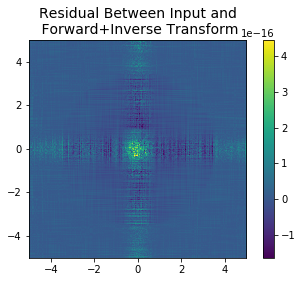

In [4]:
x_field, x_, rx = ifft(k_field, L = L,   # Note we can pass L=L, or Lk as the extent of the k-space grid.
                       ret_cubegrid=True)

plt.imshow(np.abs(x_field)-field,extent=(x.min(),x.max(),x.min(),x.max()))
plt.title("Residual Between Input and\n Forward+Inverse Transform", fontsize=14)
plt.colorbar()
plt.show();

We can also check that the xgrid returned is the same as the input xgrid:

In [5]:
x_ -x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Changing the convention

Suppose we instead required the transform

$$ \int e^{-\pi r^2} e^{-i \nu \cdot x} d^2x = e^{-\nu^2/4\pi}. $$

This is the same transform but with the Fourier-convention $(a,b) = (1,1)$. We would do this like:

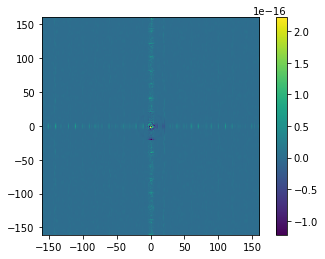

In [6]:
# Generate the k-space field, the 1D k-space grid, and the 2D magnitude grid.
k_field, k, rk = fft(field,L=L,          # Pass the field to transform, and its size 
                     ret_cubegrid=True,   # Tell it to return the grid of magnitudes.
                     a=1,b=1             # SET THE FOURIER CONVENTION
                    )

# Plot the field minus the analytic result
plt.imshow(np.abs(k_field)-np.exp(-1./(4*np.pi)*rk**2),extent=(k.min(),k.max(),k.min(),k.max()))
plt.colorbar();

Again, specifying the inverse transform with these conventions gives back the original:

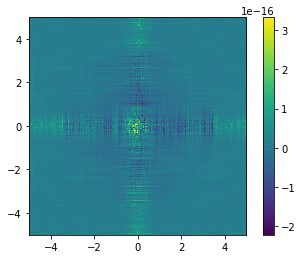

In [7]:
x_field, x_, rx = ifft(k_field, L = L,   # Note we can pass L=L, or Lk as the extent of the k-space grid.
                       ret_cubegrid=True,
                       a=1,b=1
                      )

plt.imshow(np.abs(x_field)-field,extent=(x.min(),x.max(),x.min(),x.max()))
plt.colorbar()
plt.show();

### Mixing up conventions

It may be that sometimes the forward and inverse transforms in a certain problem will have different conventions. Say the forward transform has parameters $(a,b)$, and the inverse has parameters $(a',b')$. Then first taking the forward transform, and *then* inverting it (in $n$-dimensions) would yield:

$$ \left( \frac{b'}{b(2\pi)^{a'-a}}\right)^{n/2} f\left(\frac{b'r}{b}\right), $$

and doing it the other way would yield:

$$ \left( \frac{b}{b'(2\pi)^{a'-a}}\right)^{n/2} F\left(\frac{bk}{b'}\right). $$

The ``fft`` and ``ifft`` functions handle these easily. For example, if $(a,b) = (0,2\pi)$ and $(a',b') = (0,1)$, then the 2D forward-then-inverse transform should be

$$ f(r/(2\pi))/ 2\pi, $$

and the inverse-then-forward should be

$$ 2\pi F(2\pi k). $$


/home/steven/miniconda3/envs/powerbox/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


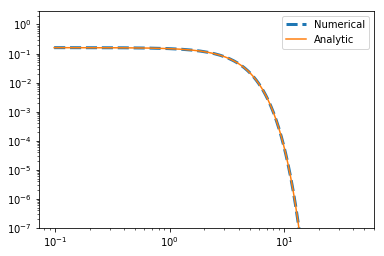

In [8]:
# Do the forward transform
k_field,k,rk = fft(field,L=L,a=0,b=2*np.pi, ret_cubegrid=True)

# Do the inverse transform, ensuring the boxsize is correct
mod_field,modx,modr = ifft(k_field,Lk=-2*k.min(),a=0,b=1, ret_cubegrid=True)

mod_field, bins = pbox.angular_average(mod_field, modr, 300)

plt.plot(bins,mod_field, label="Numerical",lw=3,ls='--')
plt.plot(bins,np.exp(-np.pi*(bins/(2*np.pi))**2)/(2*np.pi),label="Analytic")
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-7,3)
plt.show()

## Using Different Conventions in Powerbox

These fourier-transform wrappers are used inside powerbox to do the heavy lifting. That means that one can pass a power spectrum which has been defined with arbitrary conventions, and receive a fully consistent box back.

Let's say, for example, that the fourier convention in your field was to use $(a,b)=(0,1)$, so that the power spectrum of a 2D field, $\delta_x$ was given by

$$P(k) =  \frac{1}{2\pi} \int \delta_x e^{-ikx} d^2x. $$

We now wish to create a realisation with a power spectrum following these conventions. Let's say the power spectrum is $P(k) = 0.1k^{-2}$.

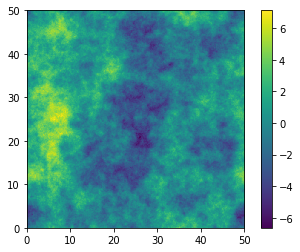

In [9]:
pb = pbox.PowerBox(
    N=512,dim=2,pk = lambda k : 0.1*k**-3., 
    a=0, b=1,        # Set the Fourier convention
    boxlength=50.0   # Has units of inverse k
)

plt.imshow(pb.delta_x(),extent=(0,50,0,50))
plt.colorbar()
plt.show()

When we check the power spectrum, we also have to remember to set the Fourier convention accordingly:

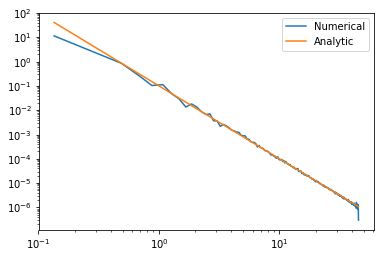

In [10]:
power, kbins = pbox.get_power(pb.delta_x(), pb.boxlength, a= 0,b =1)

plt.plot(kbins,power,label="Numerical")
plt.plot(kbins,0.1*kbins**-3.,label="Analytic")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()